# Credit Card Fraud Detection
#### By Shadi Bavar, Matthew Euliano, and Claire Parisi


##### Importing Required Libraries & Dataset

In [1]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,auc,roc_curve,recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


np.random.seed(42)

In [2]:
#Importing the Data
data = pd.read_csv('creditcard.csv')

# Get samples for each class
fraudsDF = data[data.Class == 1]
normalDF = data[data.Class == 0]
N = len(data)

print("Number of Features: ", fraudsDF.shape[1])
print("Number of Fraudulent Transactions: ",fraudsDF.shape[0], "({:.2f}%)".format(100*fraudsDF.shape[0]/N))
print("Number of Normal Transactions",normalDF.shape[0], "({:.2f}%)".format(100*normalDF.shape[0]/N))

#See the dataset
data.head()

Number of Features:  31
Number of Fraudulent Transactions:  492 (0.17%)
Number of Normal Transactions 284315 (99.83%)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Visualization

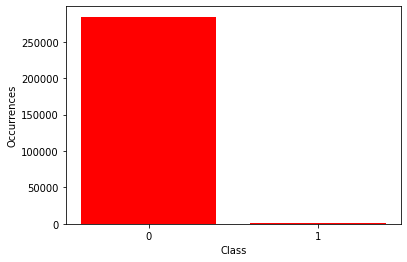

In [3]:
#Plot number of each class: data is skewed
plt.hist(data['Class'], bins = [-.4, .4, .6, 1.4], color = 'red')
plt.xlabel('Class')
plt.xticks([0, 1])
plt.ylabel('Occurrences')
plt.show()

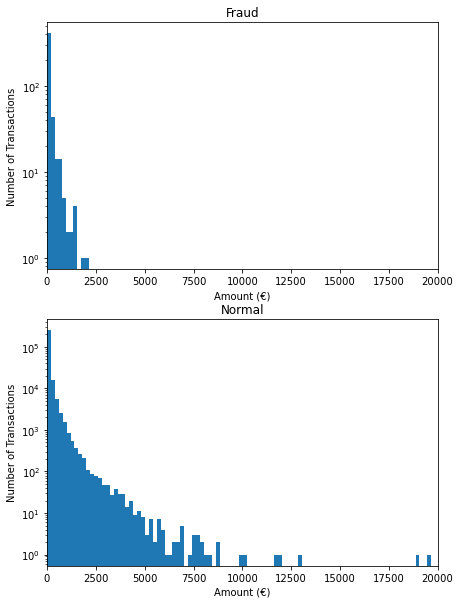

In [4]:
# Plot amount per transaction for Fraud and Normal Transactions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 10))
ax1.hist(fraudsDF.Amount, bins = round(max(fraudsDF.Amount)/200))
ax1.set_title('Fraud')
ax1.set_xlabel('Amount (€)')
ax1.set_ylabel('Number of Transactions')
ax1.set_xlim ((0, 20000))
ax1.set_yscale('log')
ax2.hist(normalDF.Amount, bins = round(max(normalDF.Amount)/200))
ax2.set_title('Normal')
ax2.set_xlabel('Amount (€)')
ax2.set_ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

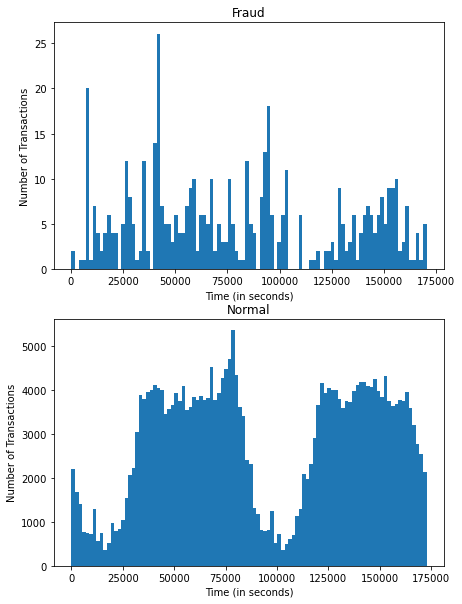

In [5]:
#Distribution of transaction times
# Plot amount per transaction for Fraud and Normal Transactions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 10))
ax1.hist(fraudsDF['Time'], bins = 100)
ax1.set_title('Fraud')
ax1.set_xlabel('Time (in seconds)')
ax1.set_ylabel('Number of Transactions')
ax2.hist(normalDF['Time'], bins = 100)
ax2.set_title('Normal')
ax2.set_xlabel('Time (in seconds)')
ax2.set_ylabel('Number of Transactions')
plt.show()

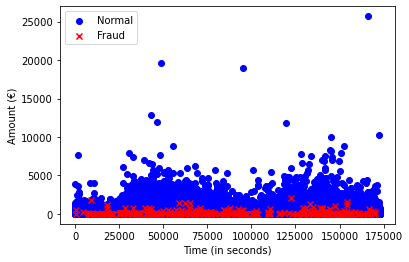

In [6]:
#Time vs Amount Feature Plot
plt.scatter(normalDF['Time'], normalDF['Amount'], color = 'blue', label = 'Normal')
plt.scatter(fraudsDF['Time'],  fraudsDF['Amount'], color = 'red', marker = 'x', label = 'Fraud')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount (€)')
plt.legend()
plt.show()

#### Regularize Features & Data Prep

In [7]:
#Scaling amount and time with rest of dataset
std_scale = StandardScaler()
data['Amount'] = std_scale.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = std_scale.fit_transform(data['Time'].values.reshape(-1, 1))

#Split dataset into inputs (x) and labels (y)
x = data.drop(['Class'], axis = 1)
y = data['Class']

#### Break dataset into Training and Testing Sets Representative of the Imbalanced Dataset

In [8]:
#split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

#check distributions of data
fraud_train_pct = y_train[y_train== 1].value_counts()/len(y_train)*100
fraud_test_pct = y_test[y_test == 1].value_counts()/len(y_test)*100

print('Training set frauds:', round(fraud_train_pct[1], 2), '%')
print('Test set frauds:', round(fraud_test_pct[1], 2), '%')

Training set frauds: 0.17 %
Test set frauds: 0.17 %


#### Undersample the Training Set to Balance the Classes

In [9]:
#find instances of fraud in training set
train_fraud_indices = np.array(y_train[y_train== 1].index)
n_train_fraud = len(train_fraud_indices)
train_nonfraud_indices = np.array(y_train[y_train== 0].index)

#Randomly select number of non-fraud transactions to match the number of fraud transactions
random_indices = np.random.choice(train_nonfraud_indices, n_train_fraud, replace = False)
undersample_indices = np.concatenate([train_fraud_indices, random_indices])

#Resample the training data
x_train_u  = x_train.loc[undersample_indices]
y_train_u = y_train.loc[undersample_indices]

#Check the new distribution of data
fraud_train_pct_u = y_train_u[y_train_u== 1].value_counts()/len(y_train_u)*100
nonfraud_train_pct_u = y_train_u[y_train_u== 0].value_counts()/len(y_train_u)*100
print('Training set frauds:', round(fraud_train_pct_u[1], 2), '%')
print('Training set non-frauds:', round(nonfraud_train_pct_u[0], 2), '%')

Training set frauds: 50.0 %
Training set non-frauds: 50.0 %


##### Cross Validation for Logisitc Regression Hyperparameter Selection

In [10]:
#Create function for logisitic regression k_fold cross validation
def lr_kfold_cv(x_train,y_train,k):
    k_fold = KFold(n_splits = k, shuffle = True, random_state = 4)
    c = [0.01, 0.1, 1, 10, 100] #weight values to try
    scores = np.zeros(len(c))
    for i in range(len(c)):

        recall = np.zeros(k)
        precision = np.zeros(k)
        f1 = np.zeros(k)
        indx = 0
        for train_index, valid_index in k_fold.split(x_train):
            lr = LogisticRegression(C = c[i], penalty= "l2", max_iter= 500) #Logistic Regression model
            lr.fit(x_train.iloc[train_index], y_train.iloc[train_index]) #Fitting the model
            y_pred = lr.predict(x_train.iloc[valid_index]) #Predicting on the validation set

            #Evaluating the model
            recall[indx] = recall_score(y_train.iloc[valid_index], y_pred)
            precision[indx] = precision_score(y_train.iloc[valid_index], y_pred)
            f1[indx] = f1_score(y_train.iloc[valid_index], y_pred)
            indx += 1

        avg_recall = np.mean(recall)
        avg_precision = np.mean(precision)
        avg_f1 = np.mean(f1)
        scores[i] = avg_f1
        print('C =', c[i], ', Recall:', avg_recall, 'Precision:', avg_precision, 'F1:', avg_f1)

    #Select model with best F1 score
    c_val = c[np.argmax(scores)]
    print('Select', c_val, 'as the best C value')
    return c_val

#5 fold CV on Undersampled Dataset to select weight parameter
c = lr_kfold_cv(x_train_u, y_train_u, 5)

C = 0.01 , Recall: 0.8796295192188625 Precision: 0.9803877213045296 F1: 0.9271522706908545
C = 0.1 , Recall: 0.912648538577607 Precision: 0.9661165942491244 F1: 0.9383554485706025
C = 1 , Recall: 0.9225801569429602 Precision: 0.9597860955767231 F1: 0.93987222562687
C = 10 , Recall: 0.9255112570571591 Precision: 0.9546931297396568 F1: 0.9390965882196491
C = 100 , Recall: 0.9282139597598617 Precision: 0.9503864941795215 F1: 0.9387785888272232
Select 1 as the best C value


##### Model Performance Analysis

In [11]:
def model_performance(model):
    # Create Confusion Matrix
    prediction = model.predict(x_test)
    cnf_matrix = confusion_matrix(y_test, prediction)
    fruads = y_test[y_test == 1]
    non_fruads = y_test[y_test == 0]

    #Calculate metrics
    pfa = cnf_matrix[0][1]/(len(non_fruads))
    print("Prob False Alarm: ", pfa)
    pmd = cnf_matrix[1][0]/(len(fruads))
    print("Prob Missed Detection: ",pmd)
    trpr = cnf_matrix[1][1]/(len(fruads))

    #Precision and Recall and F1 Score
    recall = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    print('Recall:', recall, '\nPrecision:', precision, '\nF1:', f1)

    #Plot confusion matrix
    fig = plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Fraud'])
    plt.yticks(tick_marks, ['Normal', 'Fraud'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.text(0, 0, '{}'.format(cnf_matrix[0,0]), ha='center', va='center', color='white', fontsize=12)
    plt.text(1, 0, '{}'.format(cnf_matrix[0,1]), ha='center', va='center', color='black', fontsize=12)
    plt.text(0, 1, '{}'.format(cnf_matrix[1,0]), ha='center', va='center', color='black', fontsize=12)
    plt.text(1, 1, '{}'.format(cnf_matrix[1,1]), ha='center', va='center', color='black', fontsize=12)
    plt.show()

    y_pred = model.fit(x_train_u, y_train_u).decision_function(x_test)
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False) #Can just show on 1 roc curve because it ends up being the same in both cases with just different threshold
    # fig = plt.figure()
    # plt.plot(fpr, tpr)
    # plt.plot(pfa,trpr, 'ro', label = "Baseline Model")
    # plt.show()

    return pfa, trpr, y_pred, cnf_matrix

# Logistic Regression

Prob False Alarm:  0.033975801913337086
Prob Missed Detection:  0.11224489795918367
Recall: 0.8877551020408163 
Precision: 0.04309063893016345 
F1: 0.08219178082191782


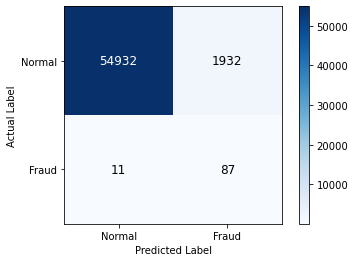

In [12]:
#Create model with best weight parameter
lr = LogisticRegression(C = c, penalty= "l2", max_iter= 500) #Logistic Regression model


lr.fit(x_train_u, y_train_u) #Fitting the model
pfa_lr1, trpr_lr1, y_pred_lr1, cnf_matrix_lr1 = model_performance(lr)

#### Model without Data Conditioning (for comparision)

Prob False Alarm:  0.00019344400675295442
Prob Missed Detection:  0.35714285714285715
Recall: 0.6428571428571429 
Precision: 0.8513513513513513 
F1: 0.7325581395348839


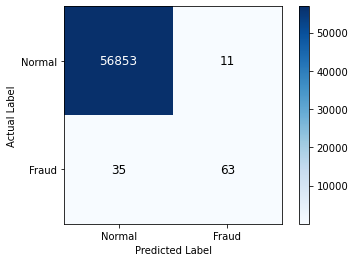

In [13]:
#use entire (unbalanced) training and testing set to evaluate model
lr = LogisticRegression(C = c, penalty= "l2", max_iter= 500) #Logistic Regression model
lr.fit(x_train,y_train)
pfa_lr2, trpr_lr2, y_pred_lr2, cnf_matrix_lr2 = model_performance(lr)

#### ROC Curve for Both Models

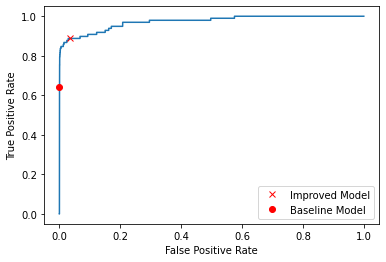

AUC: 0.9728212964983405


In [14]:
#Plot ROC curve
y_pred = lr.fit(x_train_u, y_train_u).decision_function(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False) #Can just show on 1 roc curve because it ends up being the same in both cases with just different threshold
fig = plt.figure()
plt.plot(fpr, tpr)
plt.plot(pfa_lr1,trpr_lr1, 'rx', label = "Improved Model")
plt.plot(pfa_lr2,trpr_lr2, 'ro', label = "Baseline Model")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC:', auc(fpr, tpr))

Helpful code: https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

# SVM

#### Grid Search Hyperparameter Selection

In [15]:
def Grid_Search_SVM(parameters, score, x_train, y_train):
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(SVC(probability=True), parameters, scoring="%s_macro" % score,n_jobs=-1)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)

    return clf.best_estimator_

### Radial Basis Function Kernel

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 100, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.001, 'kernel': 'rbf'}

Prob False Alarm:  0.04547692740574001
Prob Missed Detection:  0.11224489795918367
Recall: 0.8877551020408163 
Precision: 0.03254769921436588 
F1: 0.06279321544568747


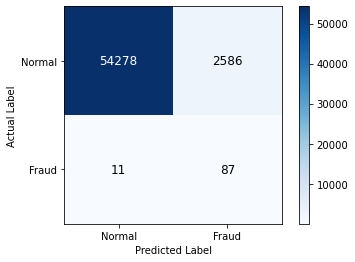

In [16]:
tuning_params_rbf = {"kernel": ["rbf"], "gamma": ['scale', 0.01,1e-3, 1e-4], "C": [1, 10, 100, 1000],"class_weight": ['balanced',{0:1, 1:1.25},{0:1, 1:1.5},{0:1, 1:1.75}]}

opt_model_rbf = Grid_Search_SVM(tuning_params_rbf, 'recall', x_train_u, y_train_u)
print()

pfa_rbf, trpr_rbf, y_pred_rbf,cnf_rbf = model_performance(opt_model_rbf)


### Linear Kernal

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'kernel': 'linear'}

Prob False Alarm:  0.047727912211592574
Prob Missed Detection:  0.09183673469387756
Recall: 0.9081632653061225 
Precision: 0.03175169461291474 
F1: 0.06135815236125475


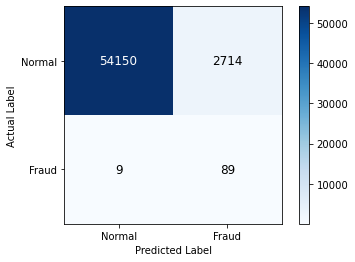

In [18]:
tuning_params_lin = {"kernel": ["linear"], "C": [1, 10, 100, 1000], "class_weight": [{0:1, 1:1.25},{0:1, 1:1.5},{0:1, 1:1.75}]}

opt_model_lin = Grid_Search_SVM(tuning_params_lin, 'recall', x_train_u, y_train_u)
print()

pfa_lin, trpr_lin, y_pred_lin, cnf_lin = model_performance(opt_model_lin)

### Polynomial Kernel

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 100, 'class_weight': 'balanced', 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}

Prob False Alarm:  0.033641671356218344
Prob Missed Detection:  0.10204081632653061
Recall: 0.8979591836734694 
Precision: 0.04397801099450275 
F1: 0.08384945212005716


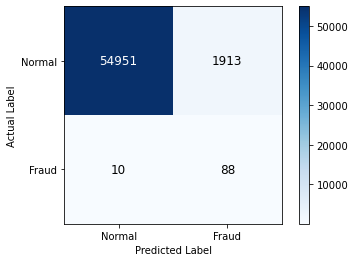

In [19]:
tuning_params_poly = {"kernel": ["poly"], "gamma": ['scale', 0.01,1e-3, 1e-4], "degree":[3,4,5], "C": [1, 10, 100, 1000],"class_weight": ['balanced',{0:1, 1:1.25},{0:1, 1:1.5},{0:1, 1:1.75}]}

opt_model_poly = Grid_Search_SVM(tuning_params_poly, 'recall', x_train_u, y_train_u)
print()

pfa_poly, trpr_poly, y_pred_poly, cnf_poly = model_performance(opt_model_poly)

### Performance Comparison

Poly AUC: 0.971932135966373
Lin AUC: 0.9687695597372319
RBF AUC: 0.9759831549389593


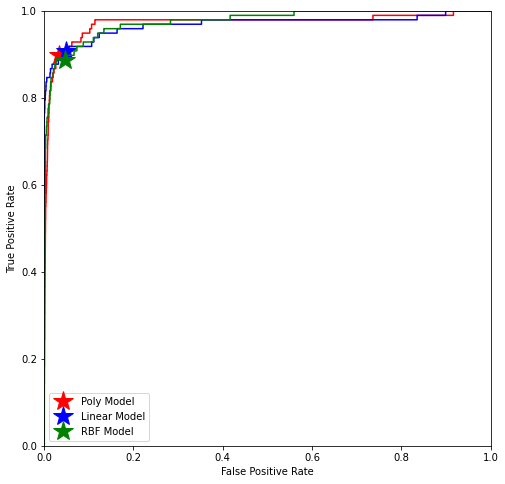

In [20]:

fig = plt.figure(figsize=[8,8])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_poly, drop_intermediate=False)
plt.plot(fpr, tpr, 'r')
plt.plot(pfa_poly,trpr_poly, 'r*', label = "Poly Model",markersize=20)
print('Poly AUC:', auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lin, drop_intermediate=False)
plt.plot(fpr, tpr,'b')
plt.plot(pfa_lin,trpr_lin, 'b*', label = "Linear Model",markersize=20)
print('Lin AUC:', auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rbf, drop_intermediate=False)
plt.plot(fpr, tpr, 'g')
plt.plot(pfa_rbf,trpr_rbf, 'g*', label = "RBF Model",markersize=20)
print('RBF AUC:', auc(fpr, tpr))

plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


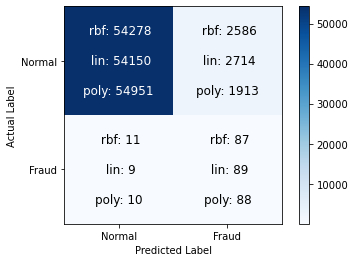

In [21]:
#Plot confusion matrix
fig = plt.figure()
plt.imshow(cnf_rbf, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Fraud'])
plt.yticks(tick_marks, ['Normal', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.text(0, 0, ' rbf: {}\n\n lin: {}\n\npoly: {}'.format(cnf_rbf[0,0],cnf_lin[0,0],cnf_poly[0,0]), ha='center', va='center', color='white', fontsize=12)
plt.text(1, 0, ' rbf: {}\n\n lin: {}\n\npoly: {}'.format(cnf_rbf[0,1],cnf_lin[0,1],cnf_poly[0,1]), ha='center', va='center', color='black', fontsize=12)
plt.text(0, 1, ' rbf: {}\n\n lin: {}\n\npoly: {}'.format(cnf_rbf[1,0],cnf_lin[1,0],cnf_poly[1,0]), ha='center', va='center', color='black', fontsize=12)
plt.text(1, 1, ' rbf: {}\n\n lin: {}\n\npoly: {}'.format(cnf_rbf[1,1],cnf_lin[1,1],cnf_poly[1,1]), ha='center', va='center', color='black', fontsize=12)
plt.show()